In [1]:
import os
import time
from datetime import datetime

import numpy as np
import pandas as pd
import scipy as sp
from tqdm import tqdm

import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(tf.keras.backend.floatx())

tf.keras.backend.set_floatx('float64')
print(tf.keras.backend.floatx())

float32
float64


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
tf.test.is_gpu_available()
# tf.config.list_physical_devices('GPU')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

### F1 - simple gauss

In [4]:
import scipy.stats as spt

norm_dist = spt.norm(loc=0.5, scale=0.01)

{
    'f1_d2': (norm_dist.cdf(1) - norm_dist.cdf(0)) ** 2,
    'f1_d4': (norm_dist.cdf(1) - norm_dist.cdf(0)) ** 4,
    'f1_d6': (norm_dist.cdf(1) - norm_dist.cdf(0)) ** 6,
    'f1_d8': (norm_dist.cdf(1) - norm_dist.cdf(0)) ** 8,
}

{'f1_d2': 1.0, 'f1_d4': 1.0, 'f1_d6': 1.0, 'f1_d8': 1.0}

In [5]:
sigma = 0.01
alpha = sigma * np.sqrt(2)
alpha_tf = tf.constant(alpha, dtype=tf.float64)
pi = np.pi
pi_sqrt_tf = tf.constant(np.pi, dtype=tf.float64)


@tf.function(input_signature=[tf.TensorSpec(shape=(None,2), dtype=tf.float64)])
def f1_d2(x):
    pre = tf.cast(1.0 / (alpha * pi_sqrt_tf) ** 2, dtype=tf.float64)
    exponent = -1 * tf.reduce_sum((x - .5) ** 2, axis=-1) / alpha ** 2
    return pre * tf.exp(exponent)

def f1_d2_np(x):
    pre = 1.0 / (alpha * np.sqrt(pi)) ** 2
    exponent = -1 * np.sum((x - .5) ** 2, axis=-1) / alpha ** 2
    return pre * np.exp(exponent)


@tf.function(input_signature=[tf.TensorSpec(shape=(None,4), dtype=tf.float64)])
def f1_d4(x):
    pre = tf.cast(1.0 / (alpha * pi_sqrt_tf) ** 4, dtype=tf.float64)
    exponent = -1 * tf.reduce_sum((x - .5) ** 2, axis=-1) / alpha ** 2
    return pre * tf.exp(exponent)


@tf.function(input_signature=[tf.TensorSpec(shape=(None,6), dtype=tf.float64)])
def f1_d6(x):
    pre = tf.cast(1.0 / (alpha * pi_sqrt_tf) ** 6, dtype=tf.float64)
    exponent = -1 * tf.reduce_sum((x - .5) ** 2, axis=-1) / alpha ** 2
    return pre * tf.exp(exponent)


@tf.function(input_signature=[tf.TensorSpec(shape=(None,8), dtype=tf.float64)])
def f1_d8(x):
    pre = tf.cast(1.0 / (alpha * pi_sqrt_tf) ** 8, dtype=tf.float64)
    exponent = -1 * tf.reduce_sum((x - .5) ** 2, axis=-1) / alpha ** 2
    return pre * tf.exp(exponent)

#### CPU Perfomance on d-dimensional sample of 1 mln size

In [6]:
temp_xx = tf.random.uniform(shape=(1_000_000,2), minval=0, maxval=1, dtype=tf.float64, seed=42)
%timeit -n 100 -r 7 f1_d2(temp_xx)

8.52 ms ± 1.84 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
temp_xx = tf.random.uniform(shape=(1_000_000,4), minval=0, maxval=1, dtype=tf.float64, seed=42)
%timeit -n 100 -r 7 f1_d4(temp_xx)

11.8 ms ± 244 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
temp_xx = tf.random.uniform(shape=(1_000_000,6), minval=0, maxval=1, dtype=tf.float64, seed=42)
%timeit -n 100 -r 7 f1_d6(temp_xx)

15.7 ms ± 296 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
temp_xx = tf.random.uniform(shape=(1_000_000,8), minval=0, maxval=1, dtype=tf.float64, seed=42)
%timeit -n 100 -r 7 f1_d8(temp_xx)

19.6 ms ± 307 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Visualize 2-dim

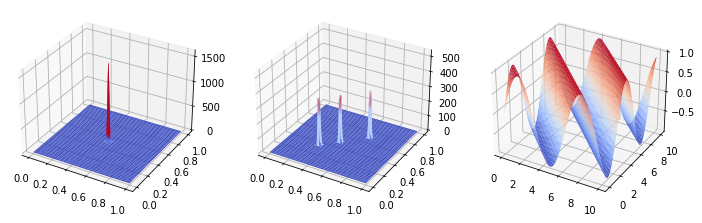

In [19]:
fig = plt.figure(figsize=(12,8))
# ax = fig.add_subplot(projection='3d')

x = y = np.arange(0, 1, 0.001)
X, Y = np.meshgrid(x, y)

ax = fig.add_subplot(1,3,1,projection='3d')
zs = np.array(f1_d2_np(np.vstack([np.ravel(X), np.ravel(Y)]).T))
Z1 = zs.reshape(X.shape)
ax.plot_surface(X, Y, Z1, cmap='coolwarm');

ax = fig.add_subplot(1,3,2,projection='3d')
zs = np.array(f2_d2_np(np.vstack([np.ravel(X), np.ravel(Y)]).T))
Z2 = zs.reshape(X.shape)
ax.plot_surface(X, Y, Z2, cmap='coolwarm');

x = y = np.arange(0, 10, 0.001)
X, Y = np.meshgrid(x, y)
ax = fig.add_subplot(1,3,3,projection='3d')
zs = np.array(f3_d2_np(np.vstack([np.ravel(X), np.ravel(Y)]).T))
Z3 = zs.reshape(X.shape)
ax.plot_surface(X, Y, Z3, cmap='coolwarm');

fig.savefig('result/01_Intro_and_Functions/3d_functions.png', format='png', bbox_inches='tight')

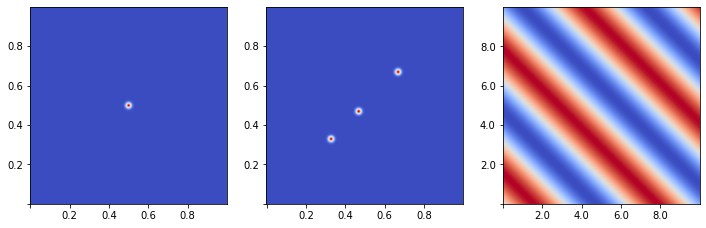

In [20]:
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(1,3,1)
ax.imshow(Z1, cmap='coolwarm', interpolation='nearest', origin='lower')
locs = ax.get_xticks()
ax.set_xticks(locs[1:-1], [''] + [d / 1000 for d in locs[2:-1]] + [])
ax.set_yticks(locs[1:-1], [''] + [d / 1000 for d in locs[2:-1]] + [])

ax = fig.add_subplot(1,3,2)
ax.imshow(Z2, cmap='coolwarm', interpolation='nearest', origin='lower')
locs = ax.get_xticks()
ax.set_xticks(locs[1:-1], [''] + [d / 1000 for d in locs[2:-1]] + [])
ax.set_yticks(locs[1:-1], [''] + [d / 1000 for d in locs[2:-1]] + [])

ax = fig.add_subplot(1,3,3)
ax.imshow(Z3, cmap='coolwarm', interpolation='nearest', origin='lower')
locs = ax.get_xticks()
ax.set_xticks(locs[1:-1], [''] + [d / 1000 for d in locs[2:-1]] + [])
ax.set_yticks(locs[1:-1], [''] + [d / 1000 for d in locs[2:-1]] + [])

fig.savefig('result/01_Intro_and_Functions/2d_functions.png', format='png', bbox_inches='tight')

### F2 - triple gauss

In [6]:
import scipy.stats as spt

norm_m1, norm_m2, norm_m3 = 0.33, 0.47, 0.67

norm_dist_1 = spt.norm(loc=norm_m1, scale=0.01)
norm_dist_2 = spt.norm(loc=norm_m2, scale=0.01)
norm_dist_3 = spt.norm(loc=norm_m3, scale=0.01)
# norm_dist = (norm_dist_1 + norm_dist_2 + norm_dist_3) / 3

norm_triple = norm_dist_1.cdf(1) - norm_dist_1.cdf(0) \
            + norm_dist_2.cdf(1) - norm_dist_2.cdf(0) \
            + norm_dist_3.cdf(1) - norm_dist_3.cdf(0)
norm_triple /= 3

{
    'f2_d2': norm_triple ** 2,
    'f2_d4': norm_triple ** 4,
    'f2_d6': norm_triple ** 6,
    'f2_d8': norm_triple ** 8,
}

{'f2_d2': 1.0, 'f2_d4': 1.0, 'f2_d6': 1.0, 'f2_d8': 1.0}

In [7]:
sigma = 0.01
alpha = sigma * np.sqrt(2)
alpha_tf = tf.constant(alpha, dtype=tf.float64)
pi = np.pi
pi_sqrt_tf = tf.constant(np.pi, dtype=tf.float64)


@tf.function(input_signature=[tf.TensorSpec(shape=(None,2), dtype=tf.float64)])
def f2_d2(x):
    pre = tf.cast(1. / (alpha * pi_sqrt_tf) ** 2, dtype=tf.float64)
    exponent1 = -1. * tf.reduce_sum(((x - norm_m1) ** 2), axis=-1) / alpha ** 2
    exponent2 = -1. * tf.reduce_sum(((x - norm_m2) ** 2), axis=-1) / alpha ** 2
    exponent3 = -1. * tf.reduce_sum(((x - norm_m3) ** 2), axis=-1) / alpha ** 2
    return pre / 3 * (tf.exp(exponent1) + tf.exp(exponent2) + tf.exp(exponent3))


def f2_d2_np(x):
    pre = 1. / (alpha * np.sqrt(pi)) ** 2
    exponent1 = -1. * np.sum(((x - norm_m1) ** 2), axis=-1) / alpha ** 2
    exponent2 = -1. * np.sum(((x - norm_m2) ** 2), axis=-1) / alpha ** 2
    exponent3 = -1. * np.sum(((x - norm_m3) ** 2), axis=-1) / alpha ** 2
    return pre / 3 * (np.exp(exponent1) + np.exp(exponent2) + np.exp(exponent3))


@tf.function(input_signature=[tf.TensorSpec(shape=(None,4), dtype=tf.float64)])
def f2_d4(x):
    pre = tf.cast(1. / (alpha * pi_sqrt_tf) ** 4, dtype=tf.float64)
    exponent1 = -1. * tf.reduce_sum(((x - norm_m1) ** 2), axis=-1) / alpha ** 2
    exponent2 = -1. * tf.reduce_sum(((x - norm_m2) ** 2), axis=-1) / alpha ** 2
    exponent3 = -1. * tf.reduce_sum(((x - norm_m3) ** 2), axis=-1) / alpha ** 2
    return pre / 3 * (tf.exp(exponent1) + tf.exp(exponent2) + tf.exp(exponent3))


@tf.function(input_signature=[tf.TensorSpec(shape=(None,6), dtype=tf.float64)])
def f2_d6(x):
    pre = tf.cast(1. / (alpha * pi_sqrt_tf) ** 6, dtype=tf.float64)
    exponent1 = -1. * tf.reduce_sum(((x - norm_m1) ** 2), axis=-1) / alpha ** 2
    exponent2 = -1. * tf.reduce_sum(((x - norm_m2) ** 2), axis=-1) / alpha ** 2
    exponent3 = -1. * tf.reduce_sum(((x - norm_m3) ** 2), axis=-1) / alpha ** 2
    return pre / 3 * (tf.exp(exponent1) + tf.exp(exponent2) + tf.exp(exponent3))


@tf.function(input_signature=[tf.TensorSpec(shape=(None,8), dtype=tf.float64)])
def f2_d8(x):
    pre = tf.cast(1. / (alpha * pi_sqrt_tf) ** 8, dtype=tf.float64)
    exponent1 = -1. * tf.reduce_sum(((x - norm_m1) ** 2), axis=-1) / alpha ** 2
    exponent2 = -1. * tf.reduce_sum(((x - norm_m2) ** 2), axis=-1) / alpha ** 2
    exponent3 = -1. * tf.reduce_sum(((x - norm_m3) ** 2), axis=-1) / alpha ** 2
    return pre / 3 * (tf.exp(exponent1) + tf.exp(exponent2) + tf.exp(exponent3))

#### CPU Perfomance on d-dimensional sample of 1 mln size

In [51]:
temp_xx = tf.random.uniform(shape=(1_000_000,2), minval=0, maxval=1, dtype=tf.float64, seed=42)
%timeit -n 100 -r 7 f2_d2(temp_xx)

21.4 ms ± 530 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [52]:
temp_xx = tf.random.uniform(shape=(1_000_000,4), minval=0, maxval=1, dtype=tf.float64, seed=42)
%timeit -n 100 -r 7 f2_d4(temp_xx)

32.2 ms ± 540 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [53]:
temp_xx = tf.random.uniform(shape=(1_000_000,6), minval=0, maxval=1, dtype=tf.float64, seed=42)
%timeit -n 100 -r 7 f2_d6(temp_xx)

42.3 ms ± 435 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [54]:
temp_xx = tf.random.uniform(shape=(1_000_000,8), minval=0, maxval=1, dtype=tf.float64, seed=42)
%timeit -n 100 -r 7 f2_d8(temp_xx)

52.5 ms ± 418 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Visualize 2-dim

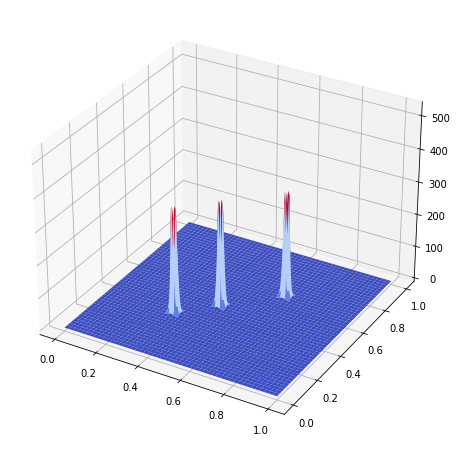

In [25]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')

x = y = np.arange(0, 1, 0.0001)
X, Y = np.meshgrid(x, y)
zs = np.array(f2_d2_np(np.vstack([np.ravel(X), np.ravel(Y)]).T))

Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z, cmap='coolwarm');

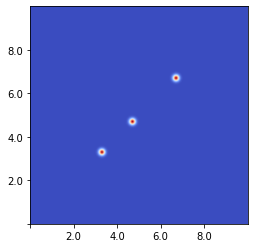

In [26]:
fig = plt.figure(figsize=(4,4))
plt.imshow(Z, cmap='coolwarm', interpolation='nearest', origin='lower')
locs, labels = plt.xticks()
plt.xticks(locs[1:-1], [''] + [d / 1000 for d in locs[2:-1]] + [])
plt.yticks(locs[1:-1], [''] + [d / 1000 for d in locs[2:-1]] + [])
plt.show()

### F3 - sin

In [8]:
{
    # from 0 to 10
    
    'f3_d2': 8 * np.cos(5) * np.sin(5) ** 3,    
    'f3_d4': 32 * (np.cos(5) + np.cos(15)) * np.sin(5) ** 5,
    'f3_d6': 128 * (np.cos(5) + np.cos(15) + np.cos(25)) * np.sin(5) ** 7,
    'f3_d8': 128 * (np.cos(35) - np.cos(45)) * np.sin(5) ** 7,
}

{'f3_d2': -2.000987472506367,
 'f3_d4': 12.350995604774042,
 'f3_d6': -49.165073816419444,
 'f3_d8': 136.37560840041465}

In [9]:
@tf.function(input_signature=[tf.TensorSpec(shape=(None,2), dtype=tf.float64)])
def f3_d2(x):
    return tf.sin(tf.reduce_sum(x, axis=-1))

def f3_d2_np(x):
    return np.sin(np.sum(x, axis=-1))


@tf.function(input_signature=[tf.TensorSpec(shape=(None,4), dtype=tf.float64)])
def f3_d4(x):
    return tf.sin(tf.reduce_sum(x, axis=-1))


@tf.function(input_signature=[tf.TensorSpec(shape=(None,6), dtype=tf.float64)])
def f3_d6(x):
    return tf.sin(tf.reduce_sum(x, axis=-1))


@tf.function(input_signature=[tf.TensorSpec(shape=(None,8), dtype=tf.float64)])
def f3_d8(x):
    return tf.sin(tf.reduce_sum(x, axis=-1))

#### CPU Perfomance on d-dimensional sample of 1 mln size

In [21]:
temp_xx = tf.random.uniform(shape=(1_000_000,2), minval=0, maxval=10, dtype=tf.float64, seed=42)
%timeit -n 100 -r 7 f3_d2(temp_xx)

4.08 ms ± 187 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
temp_xx = tf.random.uniform(shape=(1_000_000,4), minval=0, maxval=10, dtype=tf.float64, seed=42)
%timeit -n 100 -r 7 f3_d4(temp_xx)

4.54 ms ± 232 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
temp_xx = tf.random.uniform(shape=(1_000_000,6), minval=0, maxval=10, dtype=tf.float64, seed=42)
%timeit -n 100 -r 7 f3_d6(temp_xx)

5.13 ms ± 277 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
temp_xx = tf.random.uniform(shape=(1_000_000,8), minval=0, maxval=10, dtype=tf.float64, seed=42)
%timeit -n 100 -r 7 f3_d8(temp_xx)

5.77 ms ± 146 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Visualize 2-dim

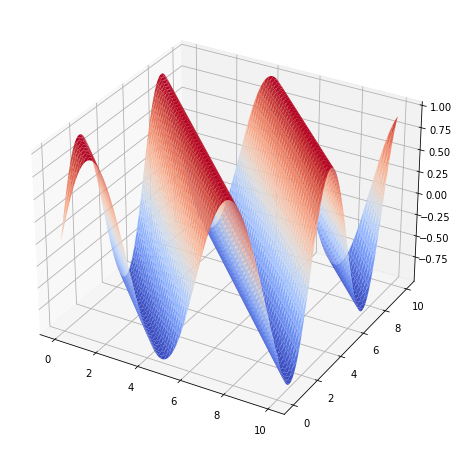

In [23]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')

x = y = np.arange(0, 10, 0.001)
X, Y = np.meshgrid(x, y)
zs = np.array(f3_d2_np(np.vstack([np.ravel(X), np.ravel(Y)]).T))

Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z, cmap='coolwarm');

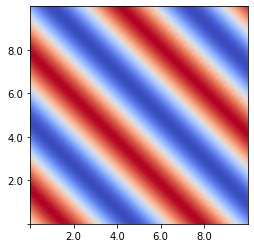

In [67]:
fig = plt.figure(figsize=(4,4))
plt.imshow(Z, cmap='coolwarm', interpolation='nearest', origin='lower')
locs, labels = plt.xticks()
plt.xticks(locs[1:-1], [''] + [d / 1000 for d in locs[2:-1]] + [])
plt.yticks(locs[1:-1], [''] + [d / 1000 for d in locs[2:-1]] + [])
plt.show()

### F5 - polynomial

In [68]:
def func1_5deps_fully_integrated(limits):
    lower, upper = limits
    lower, upper = lower[0], upper[0]
    a_lower, b_lower, c_lower, d_lower, e_lower = lower
    a_upper, b_upper, c_upper, d_upper, e_upper = upper

    val = (
        -(e_lower**4)
        * (
            a_lower * b_lower * c_lower * d_lower**3 / 12
            - a_lower * b_lower * c_lower * d_upper**3 / 12
            - a_lower * b_lower * c_upper * d_lower**3 / 12
            + a_lower * b_lower * c_upper * d_upper**3 / 12
            - a_lower * b_upper * c_lower * d_lower**3 / 12
            + a_lower * b_upper * c_lower * d_upper**3 / 12
            + a_lower * b_upper * c_upper * d_lower**3 / 12
            - a_lower * b_upper * c_upper * d_upper**3 / 12
            - a_upper * b_lower * c_lower * d_lower**3 / 12
            + a_upper * b_lower * c_lower * d_upper**3 / 12
            + a_upper * b_lower * c_upper * d_lower**3 / 12
            - a_upper * b_lower * c_upper * d_upper**3 / 12
            + a_upper * b_upper * c_lower * d_lower**3 / 12
            - a_upper * b_upper * c_lower * d_upper**3 / 12
            - a_upper * b_upper * c_upper * d_lower**3 / 12
            + a_upper * b_upper * c_upper * d_upper**3 / 12
        )
        - e_lower
        * (
            a_lower**2 * b_lower * c_lower * d_lower / 2
            - a_lower**2 * b_lower * c_lower * d_upper / 2
            - a_lower**2 * b_lower * c_upper * d_lower / 2
            + a_lower**2 * b_lower * c_upper * d_upper / 2
            - a_lower**2 * b_upper * c_lower * d_lower / 2
            + a_lower**2 * b_upper * c_lower * d_upper / 2
            + a_lower**2 * b_upper * c_upper * d_lower / 2
            - a_lower**2 * b_upper * c_upper * d_upper / 2
            + a_lower * b_lower**2 * c_lower**3 * d_lower / 6
            - a_lower * b_lower**2 * c_lower**3 * d_upper / 6
            - a_lower * b_lower**2 * c_upper**3 * d_lower / 6
            + a_lower * b_lower**2 * c_upper**3 * d_upper / 6
            - a_lower * b_upper**2 * c_lower**3 * d_lower / 6
            + a_lower * b_upper**2 * c_lower**3 * d_upper / 6
            + a_lower * b_upper**2 * c_upper**3 * d_lower / 6
            - a_lower * b_upper**2 * c_upper**3 * d_upper / 6
            - a_upper**2 * b_lower * c_lower * d_lower / 2
            + a_upper**2 * b_lower * c_lower * d_upper / 2
            + a_upper**2 * b_lower * c_upper * d_lower / 2
            - a_upper**2 * b_lower * c_upper * d_upper / 2
            + a_upper**2 * b_upper * c_lower * d_lower / 2
            - a_upper**2 * b_upper * c_lower * d_upper / 2
            - a_upper**2 * b_upper * c_upper * d_lower / 2
            + a_upper**2 * b_upper * c_upper * d_upper / 2
            - a_upper * b_lower**2 * c_lower**3 * d_lower / 6
            + a_upper * b_lower**2 * c_lower**3 * d_upper / 6
            + a_upper * b_lower**2 * c_upper**3 * d_lower / 6
            - a_upper * b_lower**2 * c_upper**3 * d_upper / 6
            + a_upper * b_upper**2 * c_lower**3 * d_lower / 6
            - a_upper * b_upper**2 * c_lower**3 * d_upper / 6
            - a_upper * b_upper**2 * c_upper**3 * d_lower / 6
            + a_upper * b_upper**2 * c_upper**3 * d_upper / 6
        )
        + e_upper**4
        * (
            a_lower * b_lower * c_lower * d_lower**3 / 12
            - a_lower * b_lower * c_lower * d_upper**3 / 12
            - a_lower * b_lower * c_upper * d_lower**3 / 12
            + a_lower * b_lower * c_upper * d_upper**3 / 12
            - a_lower * b_upper * c_lower * d_lower**3 / 12
            + a_lower * b_upper * c_lower * d_upper**3 / 12
            + a_lower * b_upper * c_upper * d_lower**3 / 12
            - a_lower * b_upper * c_upper * d_upper**3 / 12
            - a_upper * b_lower * c_lower * d_lower**3 / 12
            + a_upper * b_lower * c_lower * d_upper**3 / 12
            + a_upper * b_lower * c_upper * d_lower**3 / 12
            - a_upper * b_lower * c_upper * d_upper**3 / 12
            + a_upper * b_upper * c_lower * d_lower**3 / 12
            - a_upper * b_upper * c_lower * d_upper**3 / 12
            - a_upper * b_upper * c_upper * d_lower**3 / 12
            + a_upper * b_upper * c_upper * d_upper**3 / 12
        )
        + e_upper
        * (
            a_lower**2 * b_lower * c_lower * d_lower / 2
            - a_lower**2 * b_lower * c_lower * d_upper / 2
            - a_lower**2 * b_lower * c_upper * d_lower / 2
            + a_lower**2 * b_lower * c_upper * d_upper / 2
            - a_lower**2 * b_upper * c_lower * d_lower / 2
            + a_lower**2 * b_upper * c_lower * d_upper / 2
            + a_lower**2 * b_upper * c_upper * d_lower / 2
            - a_lower**2 * b_upper * c_upper * d_upper / 2
            + a_lower * b_lower**2 * c_lower**3 * d_lower / 6
            - a_lower * b_lower**2 * c_lower**3 * d_upper / 6
            - a_lower * b_lower**2 * c_upper**3 * d_lower / 6
            + a_lower * b_lower**2 * c_upper**3 * d_upper / 6
            - a_lower * b_upper**2 * c_lower**3 * d_lower / 6
            + a_lower * b_upper**2 * c_lower**3 * d_upper / 6
            + a_lower * b_upper**2 * c_upper**3 * d_lower / 6
            - a_lower * b_upper**2 * c_upper**3 * d_upper / 6
            - a_upper**2 * b_lower * c_lower * d_lower / 2
            + a_upper**2 * b_lower * c_lower * d_upper / 2
            + a_upper**2 * b_lower * c_upper * d_lower / 2
            - a_upper**2 * b_lower * c_upper * d_upper / 2
            + a_upper**2 * b_upper * c_lower * d_lower / 2
            - a_upper**2 * b_upper * c_lower * d_upper / 2
            - a_upper**2 * b_upper * c_upper * d_lower / 2
            + a_upper**2 * b_upper * c_upper * d_upper / 2
            - a_upper * b_lower**2 * c_lower**3 * d_lower / 6
            + a_upper * b_lower**2 * c_lower**3 * d_upper / 6
            + a_upper * b_lower**2 * c_upper**3 * d_lower / 6
            - a_upper * b_lower**2 * c_upper**3 * d_upper / 6
            + a_upper * b_upper**2 * c_lower**3 * d_lower / 6
            - a_upper * b_upper**2 * c_lower**3 * d_upper / 6
            - a_upper * b_upper**2 * c_upper**3 * d_lower / 6
            + a_upper * b_upper**2 * c_upper**3 * d_upper / 6
        )
    )
    return val

In [24]:
func1_5deps_fully_integrated([((1.0, -1.0, 2.0, 4.0, 3.0),), ((5.0, 4.0, 5.0, 8.0, 9.0),)])

14547600.0

In [25]:
func1_5deps_fully_integrated([((1.0, -1.0, -5.0, 3.4, 2.1),), ((5.0, 5.4, -1.1, 7.6, 3.5),)])

449740.933963776

In [69]:
{    
    'f5_d5': 14547600.0,
}

{'f5_d5': 14547600.0}

In [70]:
@tf.function(input_signature=[tf.TensorSpec(shape=(None,5), dtype=tf.float64)])
def f3_d5(x):
    return x[:, 0] + x[:, 1] * x[:, 2] ** 2 + x[:, 3] ** 2 * x[:, 4] ** 3

def f3_d5_np(x):
    return x[:, 0] + x[:, 1] * x[:, 2] ** 2 + x[:, 3] ** 2 * x[:, 4] ** 3

#### CPU Perfomance on d-dimensional sample of 1 mln size

In [30]:
temp_xx = tf.random.uniform(shape=(1_000_000,5), minval=0, maxval=1, dtype=tf.float64, seed=42)
%timeit -n 100 -r 7 f3_d5(temp_xx)

17.8 ms ± 93.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [31]:
temp_xx_np = temp_xx.numpy()
%timeit -n 100 -r 7 f3_d5_np(temp_xx)

40.3 ms ± 281 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Visualize 2-dim projections

In [102]:
limits = np.array([(1.0, -1.0, 2.0, 4.0, 3.0), (5.0, 4.0, 5.0, 8.0, 9.0)])

# np.random.seed(43)
# data = np.random.uniform(low=limits[0], high=limits[1], size=(10000,5))

In [103]:
# f3_d5_np(data).shape

(10000,)

In [107]:
limits.T

array([[ 1.,  5.],
       [-1.,  4.],
       [ 2.,  5.],
       [ 4.,  8.],
       [ 3.,  9.]])

In [114]:
dim_pairs = np.array([
    [0,1], [0,2], [0,3],
    [0,4], [1,2], [1,3],
    [1,4], [2,3], [2,4],
    [3,4], [-1,1], [-1,1]
]).reshape(4,3,2)
dim_pairs

array([[[ 0,  1],
        [ 0,  2],
        [ 0,  3]],

       [[ 0,  4],
        [ 1,  2],
        [ 1,  3]],

       [[ 1,  4],
        [ 2,  3],
        [ 2,  4]],

       [[ 3,  4],
        [-1,  1],
        [-1,  1]]])

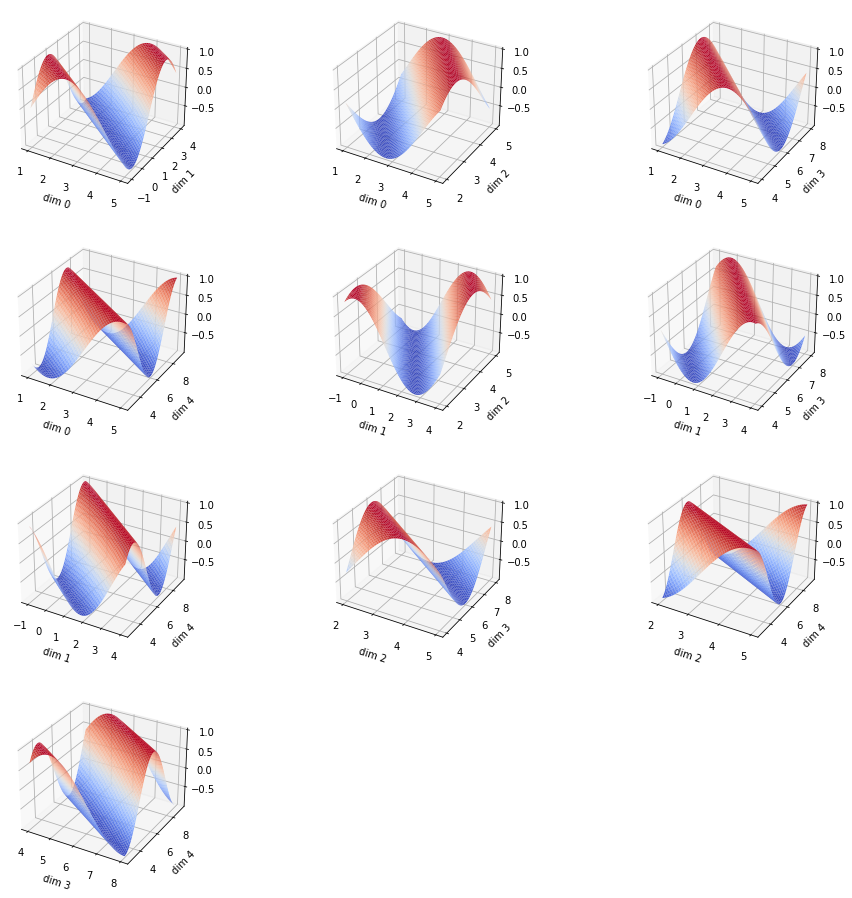

In [126]:
fig = plt.figure(figsize=(16,16))

for i in range(4):
    for j in range(3):
        d1, d2 = dim_pairs[i][j]
        if d1 * d2 < 0:
            continue
            
        ax = fig.add_subplot(4, 3, i*3+j+1, projection='3d')
        x_limits = limits.T[d1]
        y_limits = limits.T[d2]
        x = np.arange(*x_limits, 0.001)
        y = np.arange(*y_limits, 0.001)
        X, Y = np.meshgrid(x, y)
        zs = np.array(f3_d2_np(np.vstack([np.ravel(X), np.ravel(Y)]).T))
        Z = zs.reshape(X.shape)
        ax.plot_surface(X, Y, Z, cmap='coolwarm')
        ax.set_xlabel(f'dim {d1}')
        ax.set_ylabel(f'dim {d2}')
        # ax.set_zlabel('Z Label')